In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Data Exploration

In [10]:
#Use inspector to view table information
inspector = inspect(engine)
columns = inspector.get_columns('measurement')

print("---------Measurement Table---------")
for column in columns:
    print(column["name"], column["type"])
    
print("---------Station Table---------")
inspector = inspect(engine)
columns = inspector.get_columns('station')

for column in columns:
    print(column["name"], column["type"])


---------Measurement Table---------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------Station Table---------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
#Use 'engine.execute' to select first 10 rows of data from the measurement table
#and view data format
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
#Repeat for station table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [13]:
#Use a query to find the most recent date in the dataset
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [14]:
#Calculate the date one year ago, store as variable and show on screen
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query date:", query_date)

Query date: 2016-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > query_date).\
    order_by(measurement.date).all()


In [16]:
precip_df = pd.DataFrame(precip, columns=['date', 'precip'])
precip_df.set_index('date', inplace=True)
precip_df = precip_df.dropna()
precip_df

,precip
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


Text(0, 0.5, 'Precipitation (inches)')

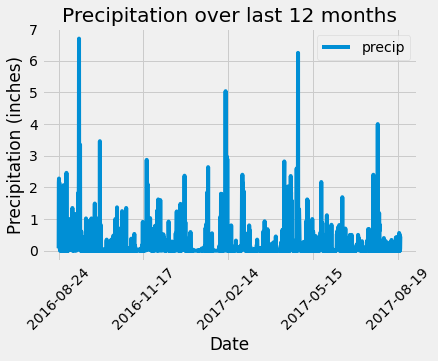

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=45);
plt.title('Precipitation over last 12 months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precip
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
#STATION ANALYSIS
# Design a query to show how many stations are available in this dataset
stations_count = session.query(measurement).group_by(measurement.station).count()
print(f"There are {stations_count} stations in the Measurement dataset")

There are 9 stations in the Measurement dataset


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

activity = session.query(measurement.station,
    func.count(measurement.station)
    ).group_by(measurement.station
    ).order_by(func.count(measurement.station).desc())

for row in activity:
    print(f" Station {row[0]} has {row[1]} records")    

most_active = activity[0]
station_id = most_active[0]

print("-----------------------------")    
print(f"Station {station_id} is the most active station")
print("-----------------------------")  



 Station USC00519281 has 2772 records
 Station USC00519397 has 2724 records
 Station USC00513117 has 2709 records
 Station USC00519523 has 2669 records
 Station USC00516128 has 2612 records
 Station USC00514830 has 2202 records
 Station USC00511918 has 1979 records
 Station USC00517948 has 1372 records
 Station USC00518838 has 511 records
-----------------------------
Station USC00519281 is the most active station
-----------------------------


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

min_temp = session.query(
    func.min(measurement.tobs)
    ).filter(measurement.station == station_id).first()
    
max_temp = session.query(
    func.max(measurement.tobs)
    ).filter(measurement.station == station_id).first()

avg_temp = session.query(
    func.avg(measurement.tobs)
    ).filter(measurement.station == station_id).first()

In [22]:
print(f"The minimum temperature recorded at station {station_id} was {min_temp[0]} degrees fahrenheit")
print(f"The maximum temperature recorded at station {station_id} was {max_temp[0]} degrees fahrenheit")
print(f"The average temperature recorded at station {station_id} was {round(avg_temp[0],2)} degrees fahrenheit")

The minimum temperature recorded at station USC00519281 was 54.0 degrees fahrenheit
The maximum temperature recorded at station USC00519281 was 85.0 degrees fahrenheit
The average temperature recorded at station USC00519281 was 71.66 degrees fahrenheit


In [23]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
tobs = session.query(measurement.date, measurement.station, measurement.tobs).\
    filter(measurement.date > query_date).\
    order_by(measurement.date).all()


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_activity = session.query(measurement.station,
    func.count(measurement.tobs)
    ).group_by(measurement.station
    ).order_by(func.count(measurement.station).desc())
    
most_active_tobs = tobs_activity[0]
tobs_station_id = most_active_tobs[0]
print(f"The most active station is {most_active_tobs[0]} with {most_active_tobs[1]} records")

The most active station is USC00519281 with 2772 records


In [25]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs2 = session.query(measurement.date, measurement.station, measurement.tobs).\
    filter(measurement.date > query_date).\
    filter(measurement.station == tobs_station_id).\
    order_by(measurement.date).all()


Text(0.5, 1.0, '12 Months of temperature data recorded at Station USC00519281')

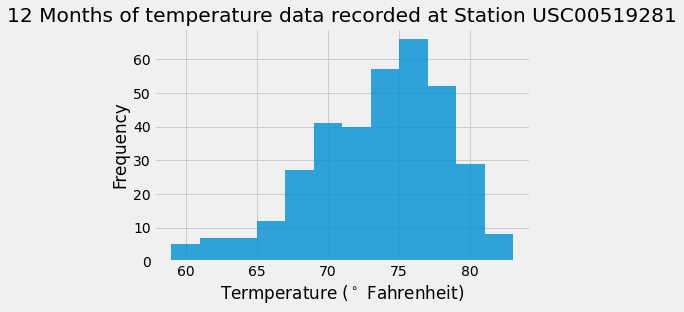

In [26]:
tobs_df = pd.DataFrame(tobs2, columns=['date', 'station', 'tobs'])
plt.hist(tobs_df['tobs'], bins=12, alpha=0.8);
plt.xlabel('Termperature ($^\circ$ Fahrenheit)')
plt.ylabel('Frequency')
plt.title(f"12 Months of temperature data recorded at Station {tobs_station_id}")

## Bonus Challenge Assignment

Hawaii is reputed to enjoy mild weather all year. 
Is there a meaningful difference between the temperature in, for example, June and December?
Identify the average temperature in June at all stations across all available years in the dataset. 
Do the same for December temperature

In [27]:
# Temperature Analysis I
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.
measurement_path = "Resources/hawaii_measurements.csv"
hawaii_data = pd.read_csv(measurement_path)

no_null = hawaii_data.dropna().copy()
no_null[['year', 'month', 'day']] = no_null['date'].str.split('-', expand=True)

june = no_null[no_null['month']=='06']
december = no_null[no_null['month']=='12']

june_tobs = june['tobs'].tolist()
december_tobs = december['tobs'].tolist()

# Statistical analysis
from scipy import stats
from numpy import mean

print(f"The average temperature in June is {round(mean(june_tobs), 2)}")
print(f"The average temperature in December is {round(mean(december_tobs), 2)}")
# Use the t-test to determine whether the difference in the means, if any, 
# is statistically significant. 

t_test = stats.ttest_ind(june_tobs, december_tobs)

print(f"The t test result is '{t_test[1]}', when rounded to 4 decimals is {round(t_test[1],4)}")



The average temperature in June is 74.89
The average temperature in December is 70.93
The t test result is '9.8415346259008e-182', when rounded to 4 decimals is 0.0


### Will you use a paired or unpaired t-test? Why

An unapired t-test is used, as the two samples of data are independent of each other (ie, the June totals do not appear in the december totals)

In [28]:
# Temperature Analysis II
# # This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

t_range = (calc_temps('2012-09-01', '2012-09-08'))
tmin = t_range[0][0]
tavg = t_range[0][1]
tmax = t_range[0][2]
y_err = tmax - tmin


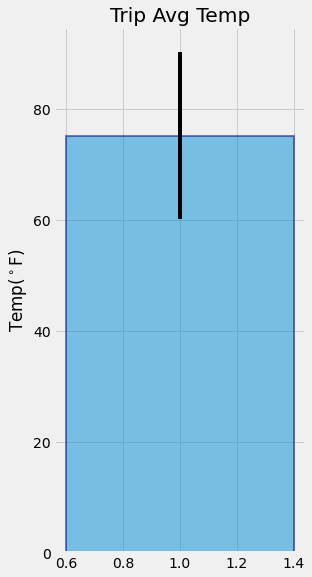

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,9))
plt.bar(1, height=tavg, width = 0.8, yerr=y_err, edgecolor="darkblue", linewidth=2, alpha=0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temp($^\circ$F)");


In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#'2012-09-01', '2012-09-08'
def calc_temps(start_date, end_date):
    
    return session.query(measurement.station, station.name, station.latitude, station.longitude, station.elevation, 
        (func.sum(measurement.prcp)),
        ).filter(measurement.station == station.station
        ).filter(measurement.date >= start_date).filter(measurement.date <= end_date  
        ).group_by(measurement.station
        ).order_by(func.sum(measurement.prcp).desc()).all()
        
prcp_data = calc_temps('2012-09-01', '2012-09-08')

for record in prcp_data:
    print(f"{record}")
    print("----------------------------------")
    

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 5.3100000000000005)
----------------------------------
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.7400000000000001)
----------------------------------
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.44)
----------------------------------
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.28)
----------------------------------
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.23000000000000004)
----------------------------------
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22)
----------------------------------
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.14)
----------------------------------


In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")
daily_normals("02-01")

[(56.0, 68.14035087719299, 78.0)]

In [34]:
# Calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = ('2012-09-01') 
end_date = ('2012-09-08')

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
dates = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
# Use *args to pass all dates in to one list, to build dataframe in next step
for date in dates:
    normals.append(*daily_normals(date))

print(normals)

[(69.0, 77.0, 82.0), (67.0, 76.66666666666667, 83.0), (69.0, 76.13725490196079, 83.0), (68.0, 76.27083333333333, 84.0), (66.0, 75.91489361702128, 84.0), (66.0, 74.91111111111111, 81.0), (64.0, 75.18, 82.0), (66.0, 76.22222222222223, 83.0)]


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'])
normals_df['date'] = trip_dates
normals_df.set_index('date', inplace=True)
normals_df

,tmin,tavg,tmax
date,,,
2012-09-01,69.0,77.000000,82.0
2012-09-02,67.0,76.666667,83.0
2012-09-03,69.0,76.137255,83.0
2012-09-04,68.0,76.270833,84.0
2012-09-05,66.0,75.914894,84.0
2012-09-06,66.0,74.911111,81.0
2012-09-07,64.0,75.180000,82.0
2012-09-08,66.0,76.222222,83.0


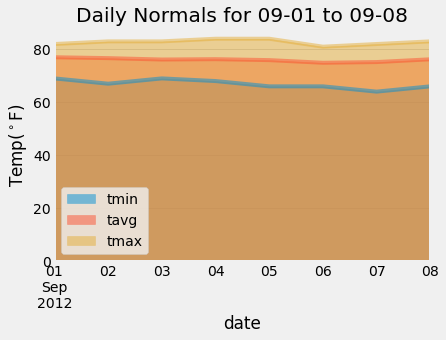

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False)
plt.title(f"Daily Normals for {dates[0]} to {dates[7]}")
plt.ylabel("Temp($^\circ$F)");


In [37]:
#Close the session
session.close()